- divides domain into 4 regions (N. Strait, S. Strait, Haro, JdF)
- plots all stns from grl_2016 edit
- calculates DIC/TA relationships from salinity
- initializes an nc file with these relationships


In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from __future__ import print_function
from numpy import *
from scipy import *
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy as sp
import cmocean
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

%matplotlib inline


In [3]:
mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

tmask = mesh.variables['tmask'][0, :, :, :]
tmask = np.abs(tmask-1)
mesh.close()

#

## Loading an initial file - 01 jan 16, sea_initial

In [4]:

#ds2 = nc.Dataset('/data/tjarniko/MEOPAR/sea_initial/v201702b/Bathy201702_12sep16.nc')

ds2 = nc.Dataset('./PhysBio_01jan16.nc')
print('ds from sea_initial')
print(ds2)

ds from sea_initial
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    title: All tracers for Bathymetry 201702 from nowcast-green 12sep16
    institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
    source: https://bitbucket.org/tjarnikova/at3/src/tip/notebooks/carbon_dev/Tools/I_ForcingFiles/Initial/Initial_from_Restart_Bathy201702.ipynb
    references: REQUIRED
    history: [2018-05-11 14:26:25] Created netCDF4 zlib=True dataset.
    comment: All Tracers, physical and biological
    dimensions(sizes): y(898), x(398), deptht(40), time_counter(1)
    variables(dimensions): float32 tn(time_counter,deptht,y,x), float32 sn(time_counter,deptht,y,x), float32 TRNDON(time_counter,deptht,y,x), float32 TRNMICZ(time_counter,deptht,y,x), float32 TRNMYRI(time_counter,deptht,y,x), float32 TRNNH4(time_counter,deptht,y,x), float32 TRNNO3(time_counter,deptht,y,x), float32 TRNTRA(time_counter,deptht,y,x)

In [5]:
sal = ds2.variables['sn']
print
mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

tmask = mesh.variables['tmask'][0, :, :, :]
tmask = np.abs(tmask-1)
mesh.close()

sal_masked = np.ma.masked_array(sal, mask=tmask)
sal1 = sal_masked[0,0,:,:]
temp = ds2.variables['tn']
temp_masked = np.ma.masked_array(temp, mask=tmask)

temp1 = temp_masked[0,0,:,:]
temp_all = temp_masked[:,:,:,:]
mask = np.zeros_like(temp1)
mask[temp1>0] = 4



## rough mask of water regions defined in Ianson (Haro, JdF, N. Strait, S. Strait) to use for assigning salinity relationships - to be refined...

In [6]:
mask[:] = 0
mask[temp1>0] = 4
for y in range(0,898):
    for x in range(0,398):
        q = temp1[y,x]
        q = np.uint64(q)
        
        if  (x <200) & (y>220) & (y<500) & (q >0) :
            mask[y,x] = 1
        if  (y >= 550) & (q > 0):
            mask[y,x] = 2
        if (x> 150) & (y>310) & (y<550) & (q>0):
            mask[y,x] = 3


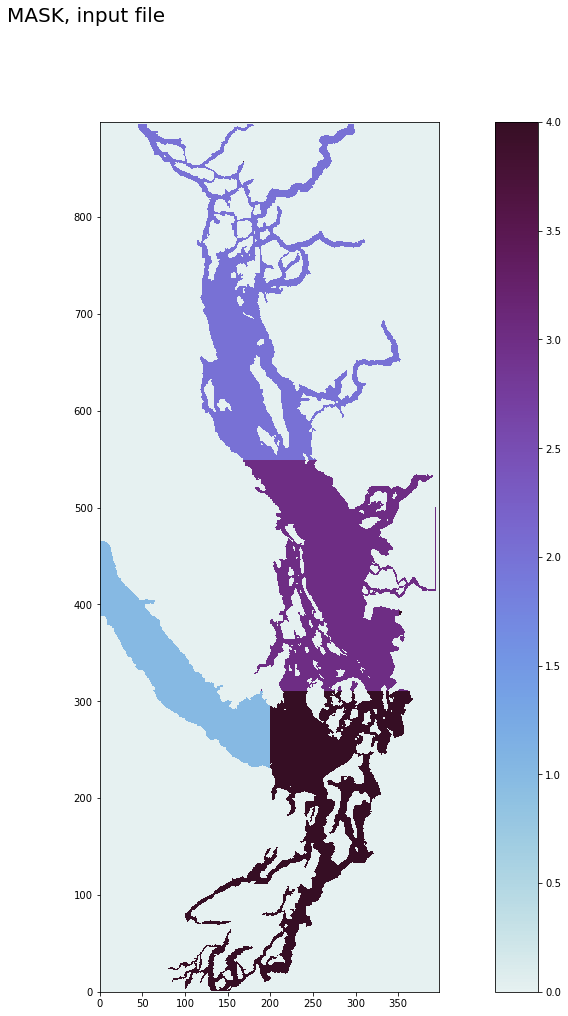

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(20, 16))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(mask, cmap=cmocean.cm.dense)
fig.colorbar(mesh)
plt.suptitle('MASK, input file',fontsize=20)

## Loading data from Debby, some edits to loc. of station 39.5, 42, 12

In [8]:
infil = loadtxt('./DATASETS/grl2016_edit.txt')

In [9]:
crid= infil[:,0]
ln = infil[:,2]
stn = infil[:,3]
lat = infil[:,6]
lon = infil[:,7]
P = infil[:,8]
T = infil[:,9]
S = infil[:,10]
ox = infil[:,11]
ox_qf = infil[:,12]
dic = infil[:,13]
alk = infil[:,15]
dic_qf = infil[:,14]
alk_qf = infil[:,16]
no3 = infil[:,17]
no3_qf = infil[:,18]
si = infil[:,19]
si_qf = infil[:, 20]
po4 = infil[:,21]
po4_qf = infil[:, 22]



## Plotting station points over bathymetry

In [10]:
mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')

nav_lon = mesh.variables['nav_lon'][:]
nav_lat = mesh.variables['nav_lat'][:]
bathy = mesh.variables['Bathymetry'][:]

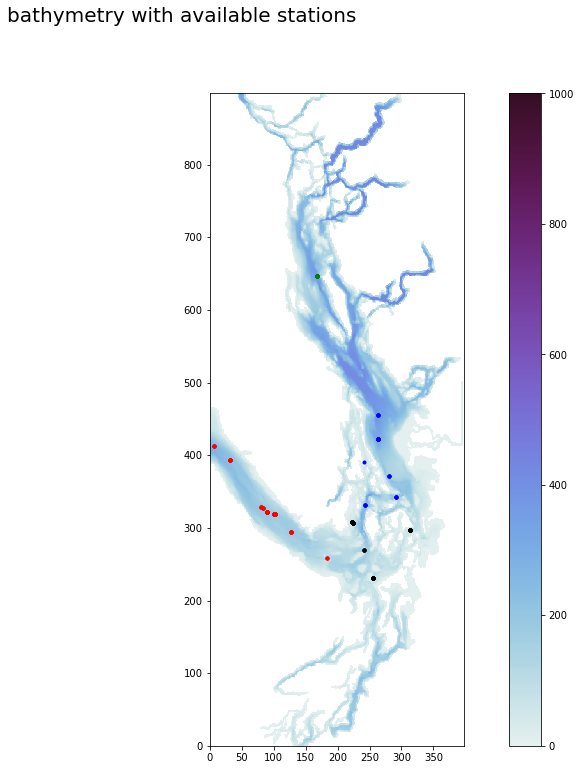

In [11]:
tag = infil[:,0]
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(bathy, cmap=cmocean.cm.dense, vmin = 00, vmax = 1000)
for w in range(0,860):
    j, i = geo_tools.find_closest_model_point(lon[w],lat[w],nav_lon,nav_lat)

    #JdF
    if  (i <200) & (j>220) & (j<500)  :
        tag[w] = 1
        ax.plot(i,j,'r.')
    #northern Strait
    if  (j >= 550) :
        tag[w] = 2
        ax.plot(i,j,'g.')
    # southern Strait    
    if (i> 150) & (j>310) & (j<550) :
        tag[w] = 3
        ax.plot(i,j,'b.')
        #puget
    if(i>=200) & (j<= 310):
        tag[w] = 4
        ax.plot(i,j,'k.')

    #ax.plot(i,j,'r.')
fig.colorbar(mesh)
plt.suptitle('bathymetry with available stations',fontsize=20)



## For each region, calculating linear relationship parameters for DIC, ALK

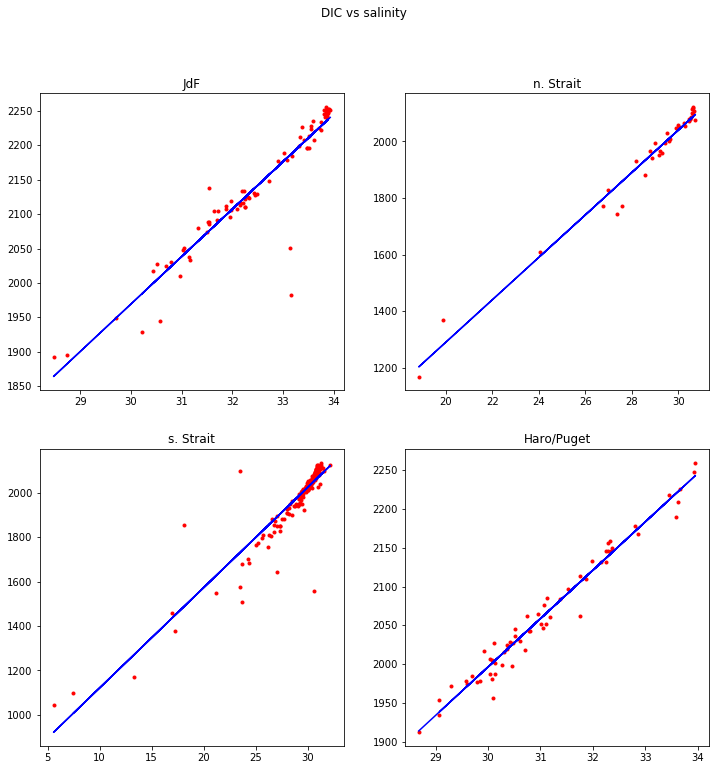

slopes:
[68.984506591824541, 75.046682176725568, 45.248982910520937, 62.275868280536201]
intercepts:
[-100.13978357455562, -210.80778641253437, 669.0670004789929, 128.20407948614184]


In [12]:
from scipy import stats 
slopes_DIC = [0,0,0,0]
ints_DIC = [0,0,0,0]
smalltit = ['JdF','n. Strait', 's. Strait', 'Haro/Puget']
fig, big_axes = plt.subplots( figsize=(12.0, 12.0) , nrows=3, ncols=1, sharey=True) 
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.tick_params(labelcolor=(1.,1.,1., 1.0), top='off', bottom='off', left='off', right='off')
    big_ax._frameon = False
    
for i in range(1,5):
        
    ax = fig.add_subplot(2,2,i)
    idx = np.where(tag == i )
    S_toplot = S[idx]
    DIC_toplot = dic[idx]
    idx_n = np.where(np.isfinite(DIC_toplot))
    S_nn = S_toplot[idx_n]
    DIC_nn = DIC_toplot[idx_n]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(S_nn,DIC_nn)
    line = slope*S_nn+intercept
    slopes_DIC[i-1] = slope
    ints_DIC[i-1] = intercept
    ax.plot(S_nn,DIC_nn,'r.')
    ax.plot(S_nn,line,'-b')
    tit = smalltit[i-1]
    ax.set_title(tit)
    
    
fig.set_facecolor('w')
plt.suptitle('DIC vs salinity')
plt.show()

print('slopes:')
print(slopes_DIC)
print('intercepts:')
print(ints_DIC)


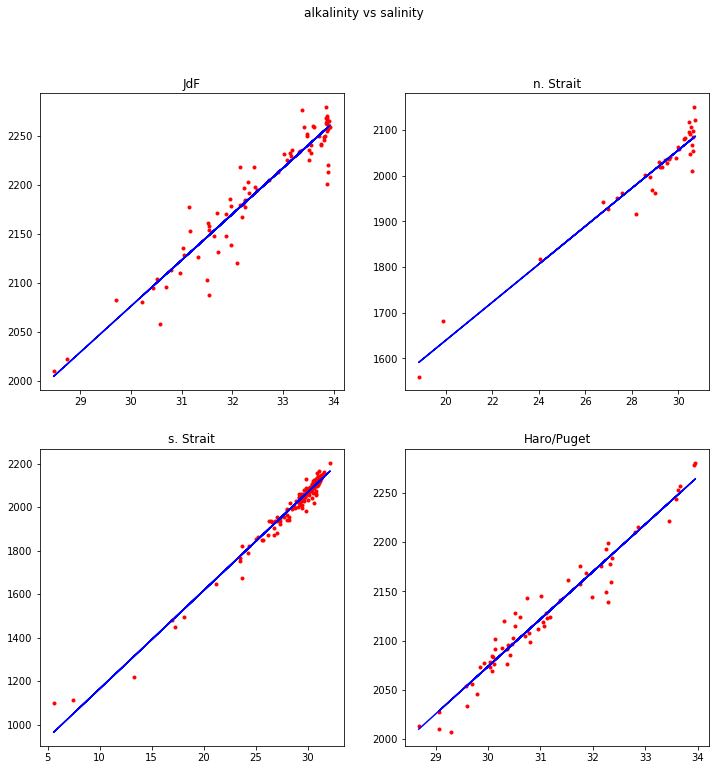

slopes:
[46.987083509452937, 41.703959570158162, 45.255106772714242, 48.099718320884534]
intercepts:
[666.6180299218554, 805.39142381007036, 712.25447700734412, 630.84821673141755]


In [13]:
from scipy import stats
slopes_alk = [0,0,0,0]
ints_alk = [0,0,0,0]
smalltit = ['JdF','n. Strait', 's. Strait', 'Haro/Puget']
fig, big_axes = plt.subplots( figsize=(12.0, 12.0) , nrows=3, ncols=1, sharey=True) 
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.tick_params(labelcolor=(1.,1.,1., 1.0), top='off', bottom='off', left='off', right='off')
    big_ax._frameon = False
    
for i in range(1,5):
        
    ax = fig.add_subplot(2,2,i)
    idx = np.where(tag == i )
    S_toplot = S[idx]
    alk_toplot = alk[idx]
    idx_n = np.where(np.isfinite(alk_toplot))
    S_nn = S_toplot[idx_n]
    alk_nn = alk_toplot[idx_n]
    
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(S_nn,alk_nn)
    line = slope*S_nn+intercept
    slopes_alk[i-1] = slope
    ints_alk[i-1] = intercept
    ax.plot(S_nn,alk_nn,'r.')
    ax.plot(S_nn,line,'-b')
    tit = smalltit[i-1]
    ax.set_title(tit)
    
    
fig.set_facecolor('w')
plt.suptitle('alkalinity vs salinity')
plt.show()

print('slopes:')
print(slopes_alk)
print('intercepts:')
print(ints_alk)

## Creating 3d regional mask, parameterizing DIC, ALK on whole domain according to slopes/intercepts above


In [14]:
sal.shape
salm = np.zeros_like(sal)
sal2 = sal[:]
salm[:] = 0
salm[sal2>0] = 4
for y in range(0,898):
    for x in range(0,398):
        q = temp1[y,x]
        q = np.uint64(q)
        
        if  (x <200) & (y>220) & (y<500) & (q >0) :
            salm[:,:,y,x] = 1
        if  (y >= 550) & (q > 0):
            salm[:,:,y,x] = 2
        if (x> 150) & (y>310) & (y<550) & (q>0):
            salm[:,:,y,x] = 3
            
salm[sal2 == 0] = 0
#salm is a mask that gives you the region tag for cells that have data
#salm[:,:,470,300]

In [15]:
w = np.zeros(3)
w[0] =  1
w[1] = 0
w[2] = 5

w[(w<5) & (w != 0)] = 2
print(w)

[ 2.  0.  5.]


In [16]:

sal2 = sal[:]
DIC = sal[:]
ALK = sal[:]


for i in range(1,5):
    ind = np.where(salm==i)
    
    ts = slopes_DIC[i-1]
    ti = ints_DIC[i-1]
    
    tsa = slopes_alk[i-1]
    tia = ints_alk[i-1]
    
    DIC[ind] = sal2[ind]*ts + ti
    ALK[ind] =  sal2[ind]*tsa + tia
    
DIC_masked = np.ma.masked_array(DIC, mask=tmask)
ALK_masked = np.ma.masked_array(ALK, mask=tmask)


DIC_masked[(DIC_masked <600) & (tmask ==False)] = 600
ALK_masked[(ALK_masked < 600) & (tmask ==False)] = 600    

DIC_masked[0,0,380:430,390]

masked_array(data = [-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- 600.0 600.0 -- -- -- -- -- -- -- -- -- -- -- --
 -- --],
             mask = [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True],
       fill_value = 1e+20)

In [17]:
#DIC[DIC<0] = 0

In [18]:
print('Salinity at pt 250, 250')
print(sal[:,:,250,250])
print('DIC at pt 250, 250')
print(DIC[:,:,250,250])
print('ALK at pt 250, 250')
print(ALK[:,:,250,250])
print('**')
print(np.min(DIC))

Salinity at pt 250, 250
[[ 30.375   30.375   30.4375  30.4375  30.4375  30.5     30.5     30.5
   30.5     30.5     30.5     30.5     30.5625  30.5625  30.5625  30.5625
   30.5625  30.5625  30.5625  30.5625  30.5625  30.5625  30.5625  30.875
   31.375   31.6875  31.75    31.8125   0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.    ]]
DIC at pt 250, 250
[[ 2019.83361816  2019.83361816  2023.72583008  2023.72583008
   2023.72583008  2027.61804199  2027.61804199  2027.61804199
   2027.61804199  2027.61804199  2027.61804199  2027.61804199
   2031.51025391  2031.51025391  2031.51025391  2031.51025391
   2031.51025391  2031.51025391  2031.51025391  2031.51025391
   2031.51025391  2031.51025391  2031.51025391  2050.97143555  2082.109375
   2101.57055664  2105.46289062  2109.35498047     0.             0.             0.
      0.             0.             0.             0.             0.             0.
      0.             0.             0.  

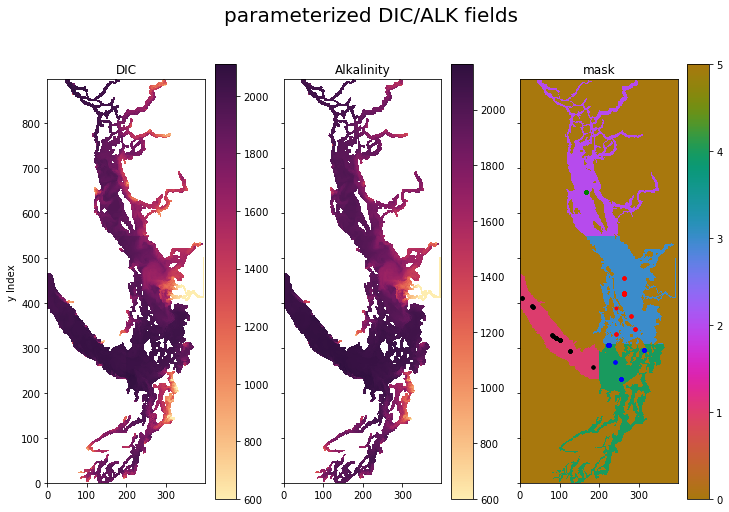

In [19]:

# DIC_masked = np.ma.masked_array(DIC, mask=tmask)
# ALK_masked = np.ma.masked_array(ALK, mask=tmask)
DIC_s = DIC_masked[0,0,:,:]
ALK_s = ALK_masked[0,0,:,:]

fig, axs = plt.subplots(1, 3, figsize=(12, 8), sharey=True)
cmap = plt.get_cmap('jet')
cmap.set_bad('burlywood')
    
time_steps = (0,1,2)
for ax, t in zip(axs, time_steps):
    if t == 0 :
        tplt = DIC_s
        ax.set_title('DIC')
        viz_tools.set_aspect(ax)
        mesh1 = ax.pcolormesh(tplt, cmap=cmocean.cm.matter)
    if t == 1 :
        tplt = ALK_s
        ax.set_title('Alkalinity')
        viz_tools.set_aspect(ax)
        mesh1 = ax.pcolormesh(tplt, cmap=cmocean.cm.matter )
    if t == 2 :
        tplt = mask
        ax.set_title('mask')
        viz_tools.set_aspect(ax)
        mesh1 = ax.pcolormesh(tplt, cmap=cmocean.cm.phase, vmin = 0, vmax = 5 )
        for w in range(0,860):
            j, i = geo_tools.find_closest_model_point(lon[w],lat[w],nav_lon,nav_lat)

            #JdF
            if  (i <200) & (j>220) & (j<500)  :
                tag[w] = 1
                ax.plot(i,j,'k.')
            #northern Strait
            if  (j >= 550) :
                tag[w] = 2
                ax.plot(i,j,'g.')
            # southern Strait    
            if (i> 150) & (j>310) & (j<550) :
                tag[w] = 3
                ax.plot(i,j,'r.')
                #puget
            if(i>=200) & (j<= 310):
                tag[w] = 4
                ax.plot(i,j,'b.')

    viz_tools.set_aspect(ax)
    #mesh = ax.pcolormesh(tplt, cmap=cmocean.cm.algae)
    cbar = fig.colorbar(mesh1, ax=ax)

#     ax.set_xlabel('x Index')
#     if t == 0:
#         cbar.set_label('DIC')
#     if t == 1:
#         cbar.set_label('ALK')
axs[0].set_ylabel('y Index')


plt.suptitle('parameterized DIC/ALK fields',fontsize=20)

## create NC file and make sure it works

In [20]:
dsin = ds2

#output file
ncname = 'init_DICTA_010116.nc'
dsout = nc.Dataset(ncname, "w", format="NETCDF4")
#Copy dimensions
for dname, the_dim in dsin.dimensions.items():
    print(dname)
    print(len(the_dim))
    dsout.createDimension(dname, len(the_dim) if not the_dim.isunlimited() else None)
# Copy variables
for v_name, varin in dsin.variables.items():
    outVar = dsout.createVariable(v_name, varin.datatype, varin.dimensions)
    print(varin.datatype)
    
    # Copy variable attributes
    outVar.setncatts({k: varin.getncattr(k) for k in varin.ncattrs()})
    
    outVar[:] = varin[:]

y
898
x
398
deptht
40
time_counter
1
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


In [21]:
DIC = dsout.createVariable('TRNDIC',np.float32,('time_counter','deptht','y','x'))
TA = dsout.createVariable('TRNTA',np.float32,('time_counter','deptht','y','x'))

In [22]:

dsout['TRNDIC'][:] = DIC_masked[:]
dsout['TRNTA'][:] = ALK_masked[:]

## Plot nc file

In [23]:
w = nc.Dataset(ncname)
q = w.variables['TRNTA']

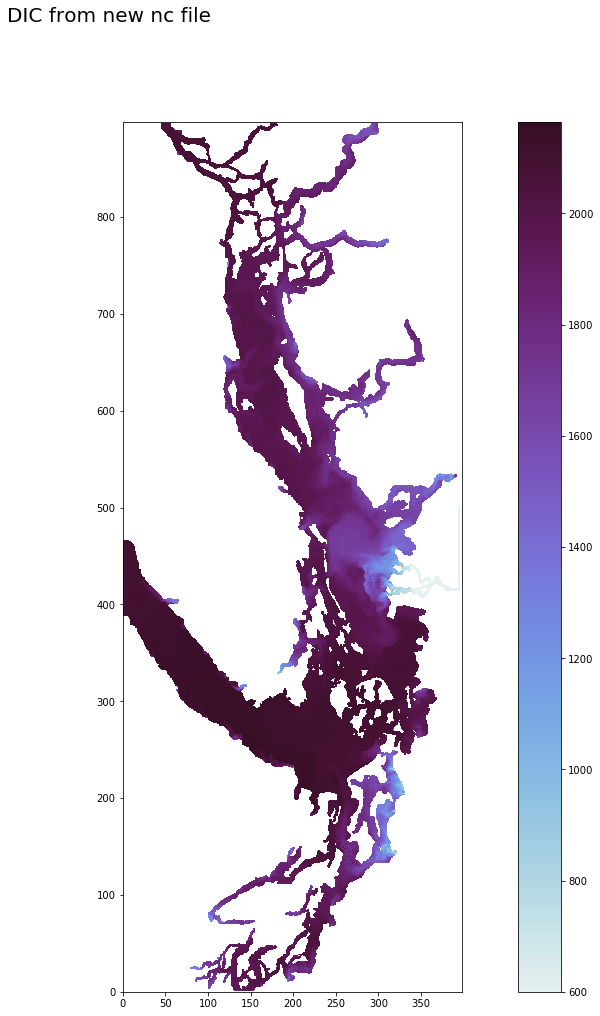

In [24]:
DIC_test = q[:]
DIC_t = DIC_test[0,0,:,:]

fig, ax = plt.subplots(1, 1, figsize=(20, 16))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(DIC_t, cmap=cmocean.cm.dense)
fig.colorbar(mesh)
plt.suptitle('DIC from new nc file',fontsize=20)

In [25]:
#dsout.close()

In [26]:
DICdat = dsout.variables['TRNDIC'][:]
DICdat.shape
print(DICdat[0,1,250,250])
q = np.where(DICdat <0)
print(q)

2019.83
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [27]:
np.ma.MaskedArray.min(DICdat)

600.0

In [28]:
dsout.close()